In [1]:
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons, TextBox # Matplotlib widgets
import matplotlib.pylab as plt # Plotting interface
import numpy as np
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, RazorThinExponentialDiskPotential, BurkertPotential # GALPY potentials
from galpy.potential import calcRotcurve # composed rotation curve calculation for plotting
from astropy import units # Physical/real units data managing
from astropy import table as Table # For fast and easy reading / writing with tables using numpy library
import emcee
import corner
import time
import pandas as pd
import multiprocessing as mp
from scipy.optimize import fsolve


import ipywidgets as widgets


  Referenced from: /Library/Python/3.7/site-packages/libgalpy.cpython-37m-darwin.so
  Reason: image not found' 


In [2]:
input_params=Table.Table.read('../input_params.txt', format='ascii.tab') # Initial parameters


In [3]:
input_params

component,mass,threshold_mass,a (kpc),threshold_a,b (kpc),threshold_b
str12,float64,float64,float64,int64,float64,int64
BULGE,110000000.0,1.0,0.0,20,0.495,70
THIN DISK,3900000000.0,1.0,5.3,90,0.25,1
THICK DISK,39000000000.0,0.5,2.6,20,0.8,1
EXP DISK,500.0,0.5,5.3,90,0.0,0
DARK HALO,140000000000.0,1.0,13.0,90,0.0,0
BURKERT HALO,8000000.0,1.0,20.0,90,0.0,0


In [4]:
tt=Table.Table.read('../rot_curve.txt', format='ascii.tab') # Rotation curve

x_offset = 0.0  # It defines a radial coordinate offset as user input
r_0=1*units.kpc # units 
v_0=220*units.km/units.s # units 

# Real data:
r_data=tt['r']-x_offset # The txt file must contain the radial coordinate values in kpc
v_c_data=tt['vel'] # velocity in km/s
v_c_err_data = tt['e_vel'] # and velocity error in km/s

# This loop is needed since galpy fails when r=0 or very close to 0
for i in range(len(r_data)):
    if r_data[i]<1e-3:
        r_data[i]=1e-3



In [5]:
class MiyamotoNagaiP:
    def __init__(self, dict_params):
        self.amp = dict_params['amp']
        self.a = dict_params['a']
        self.b = dict_params['b']
    
    def __str__(self):
        return f"amp={self.amp}, a={self.a}, b={self.b}"
    
    def __repr__(self):
        return f"amp={self.amp}, a={self.a}, b={self.b}"
        
class MassScaleP:
    def __init__(self, dict_params):
        self.amp = dict_params['amp']
        self.a = dict_params['a']
    
    def __str__(self):
        return f"amp={self.amp}, a={self.a}"
    
    def __repr__(self):
        return f"amp={self.amp}, a={self.a}"
        

In [15]:
amp1 = widgets.FloatSlider(min=110000000.0*10**(-1), max=110000000.0*10**(1), step=110000000.0*0.1)
b1 = widgets.FloatSlider(min=0.495*(100-70)/100, max=0.495*(100+70)/100, step=0.495*0.1)
ui = widgets.HBox([amp1, b1])
def f(amp1, b1):
    global bulge_potential
    bulge_dict = {'amp': amp1, 'a':0, 'b': b1 }
    bulge_potential = MiyamotoNagaiP(bulge_dict)
    print((amp1, b1))
bulge_params = widgets.interactive_output(f, {'amp1': amp1, 'b1': b1})
display(ui, bulge_params)

Output()

In [7]:
amp2 = widgets.FloatSlider(min=3900000000.0*10**(-1), max=3900000000.0*10**(1), step=3900000000.0*0.1)
a2 = widgets.FloatSlider(min=5.3*(100-90)/100, max=5.3*(100+90)/100, step=5.3*0.1)
b2 = widgets.FloatSlider(min=0.25*(100-90)/100, max=0.25*(100+90)/100, step=0.25*0.1)
ui = widgets.HBox([amp2, a2, b2])
def f(amp2, a2, b2):
    global thin_disk_potential
    thin_disk_dict = {'amp': amp2, 'a':a2, 'b': b2 }
    thin_disk_potential = MiyamotoNagaiP(thin_disk_dict)
    print((amp2, a2, b2))

thin_disk_params = widgets.interactive_output(f, {'amp2': amp2, 'a2': a2, 'b2': b2})

display(ui, thin_disk_params)



Output()

In [8]:
amp3 = widgets.FloatSlider(min=39000000000.0*10**(-0.5), max=39000000000.0*10**(0.5), step=39000000000.0*0.1)
a3 = widgets.FloatSlider(min=2.6*(100-20)/100, max=2.6*(100+20)/100, step=2.6*0.1)
b3 = widgets.FloatSlider(min=0.8*(100-90)/100, max=0.8*(100+90)/100, step=0.8*0.1)
ui = widgets.HBox([amp3, a3, b3])
def f(amp3, a3, b3):
    global thick_disk_potential
    thick_disk_dict = {'amp': amp3, 'a':a3, 'b': b3 }
    thick_disk_potential = MiyamotoNagaiP(thick_disk_dict)
    print((amp3, a3, b3))

thick_disk_params = widgets.interactive_output(f, {'amp3': amp3, 'a3': a3, 'b3': b3})

display(ui, thin_disk_params)


Output(outputs=({'output_type': 'stream', 'text': '(390000000.0, 0.53, 0.025)\n', 'name': 'stdout'},))

In [9]:
amp4 = widgets.FloatSlider(min=500.0*10**(-0.5), max=500.0*10**(0.5), step=500.0*0.1)
h_r = widgets.FloatSlider(min=5.3*(100-90)/100, max=5.3*(100+90)/100, step=5.3*0.1)
ui = widgets.HBox([amp4, h_r ])
def f(amp4, h_r):
    global exp_disk_potential
    exp_disk_dict = {'amp': amp4, 'a': h_r}
    exp_disk_potential = MassScaleP(exp_disk_dict)
    print((amp4, h_r))
exp_disk_params = widgets.interactive_output(f, {'amp4': amp4, 'h_r': h_r})
display(ui, exp_disk_params)

Output()

In [10]:
amp5 = widgets.FloatSlider(min=140000000000.0*10**(-1), max=140000000000.0*10**(1), step=140000000000.0*0.1)
a5 = widgets.FloatSlider(min=13*(100-90)/100, max=13*(100+90)/100, step=13*0.1)
ui = widgets.HBox([amp5, a5 ])
def f(amp5, a5):
    global dark_halo_potential
    dark_halo_dict = {'amp': amp5, 'a': a5}
    dark_halo_potential = MassScaleP(dark_halo_dict)
    print((amp5, a5))
dark_halo_params = widgets.interactive_output(f, {'amp5': amp5, 'a5': a5})
display(ui, dark_halo_params)

Output()

In [11]:
amp6 = widgets.FloatSlider(min=8000000.0*10**(-1), max=8000000.0*10**(1), step=8000000.0*0.1)
a6 = widgets.FloatSlider(min=20*(100-90)/100, max=20*(100+90)/100, step=20*0.1)
ui = widgets.HBox([amp6, a6 ])
def f(amp6, a6):
    global burkert_halo_potential
    burkert_halo_dict = {'amp': amp6, 'a': a6}
    burkert_halo_potential = MassScaleP(burkert_halo_dict)
    print((amp6, a6))
burkert_halo_params = widgets.interactive_output(f, {'amp6': amp6, 'a6': a6})
display(ui, burkert_halo_params)

Output()

In [12]:
lista=np.linspace(0.001, 1.02*np.max(r_data), 10*len(r_data))

In [13]:
bulge_potential, thin_disk_potential, thick_disk_potential, exp_disk_potential, dark_halo_potential, burkert_halo_potential

(amp=11000000.0, a=0, b=0.1485,
 amp=390000000.0, a=0.53, b=0.025,
 amp=12332882874.65668, a=2.08, b=0.08,
 amp=158.11388300841898, a=0.53,
 amp=14000000000.0, a=1.3,
 amp=800000.0, a=2.0)

In [14]:
MN_Bulge_p= MiyamotoNagaiPotential(amp=bulge_potential.amp*units.Msun,
                                   a=bulge_potential.a*units.kpc,
                                   b=bulge_potential.b*units.kpc,
                                   normalize=False,
                                   ro=r_0, vo=v_0)
MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=thin_disk_potential.amp*units.Msun,
                                       a=thin_disk_potential.a*units.kpc,
                                       b=thin_disk_potential.b*units.kpc,
                                       normalize=False,
                                       ro=r_0, vo=v_0)
MN_Thick_Disk_p= MiyamotoNagaiPotential(amp=thick_disk_potential.amp*units.Msun,
                                        a=thick_disk_potential.a*units.kpc,
                                        b=thick_disk_potential.b*units.kpc,
                                        normalize=False,
                                        ro=r_0, vo=v_0)
EX_Disk_p = RazorThinExponentialDiskPotential(amp=exp_disk_potential.amp*(units.Msun/(units.pc**2)), 
                                              hr=exp_disk_potential.a*units.kpc, maxiter=20, tol=0.001, 
                                              normalize=False, ro=r_0, vo=v_0, new=True, glorder=100)
NFW_p = NFWPotential(amp=dark_halo_potential.amp*units.Msun, 
                     a=dark_halo_potential.a*units.kpc, normalize=False, ro=r_0, vo=v_0)
BK_p = BurkertPotential(amp=burkert_halo_potential.amp*units.Msun/(units.kpc)**3, 
                        a=burkert_halo_potential.a*units.kpc, normalize=False, ro=r_0, vo=v_0)

# Circular velocities in km/s
MN_Bulge = calcRotcurve(MN_Bulge_p, lista, phi=None)*220
MN_Thin_Disk = calcRotcurve(MN_Thin_Disk_p, lista, phi=None)*220
MN_Thick_Disk = calcRotcurve(MN_Thick_Disk_p, lista, phi=None)*220
EX_Disk = calcRotcurve(EX_Disk_p, lista, phi=None)*220
NFW = calcRotcurve(NFW_p, lista, phi=None)*220
BK = calcRotcurve(BK_p, lista, phi=None)*220

# Circular velocity for the composition of 5 potentials in km/s
v_circ_comp = calcRotcurve([MN_Bulge_p,MN_Thin_Disk_p,MN_Thick_Disk_p, EX_Disk_p, NFW_p, BK_p], lista, phi=None)*220



In [55]:
bulge_potential

amp=11000000.0, a=0, b=0.1485

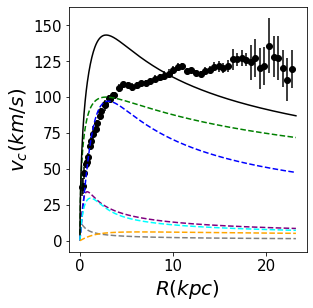

In [60]:

fig = plt.figure(1)
ax = fig.add_axes((0.41, 0.1, 0.55, 0.85))

#ax.yaxis.set_ticks_position('both')
#ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)

# Data
CV_galaxy = ax.errorbar(r_data, v_c_data, v_c_err_data,  c='k', fmt='', ls='none')
CV_galaxy_dot = ax.scatter(r_data, v_c_data, c='k')

# A plot for each rotation curve with the colors indicated below
MN_b_plot, = ax.plot(lista, MN_Bulge, linestyle='--', c='gray')
MN_td_plot, = ax.plot(lista, MN_Thin_Disk, linestyle='--', c='purple')
MN_tkd_plot, = ax.plot(lista, MN_Thick_Disk, linestyle='--', c='blue')
EX_d_plot, = ax.plot(lista, EX_Disk, linestyle='--', c='cyan')
NFW_plot, = ax.plot(lista, NFW, linestyle='--', c='green')
BK_plot, = ax.plot(lista, BK, linestyle='--', c='orange')

# Composed rotation curve
v_circ_comp_plot, = ax.plot(lista, v_circ_comp, c='k')


ax.set_xlabel(r'$R(kpc)$', fontsize=20)
ax.set_ylabel(r'$v_c(km/s)$', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=15)

[None, None, None, None, None, None, None, None, None, None, None, None]

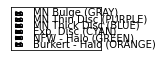

In [61]:
rax = plt.axes((0.07, 0.8, 0.21, 0.15))
check = CheckButtons(rax, ('MN Bulge (GRAY)', 'MN Thin Disc (PURPLE)', 'MN Thick Disc (BLUE)', 'Exp. Disc (CYAN)', 'NFW - Halo (GREEN)', 'Burkert - Halo (ORANGE)'), (True, True, True, True, True, True))

for r in check.rectangles: # Checkbox options-colors
    r.set_facecolor("lavender") 
    r.set_edgecolor("black")
    #r.set_alpha(0.2) 

[ll.set_color("black") for l in check.lines for ll in l]
[ll.set_linewidth(2) for l in check.lines for ll in l]


In [62]:
MN_b_amp_ax = fig.add_axes((0.09,0.75,0.17,0.03))
MN_b_amp_s = Slider(MN_b_amp_ax, r"$M$($M_\odot$)", input_params['mass'][0]/(10**input_params['threshold_mass'][0]), input_params['mass'][0]*(10**input_params['threshold_mass'][0]), valinit=input_params['mass'][0], color='gray', valfmt='%1.3E')
MN_b_a_ax = fig.add_axes((0.09,0.72,0.17,0.03))
MN_b_a_s = Slider(MN_b_a_ax, "$a$ ($kpc$)", 0, 0.1*input_params['threshold_a'][0], valinit=input_params['a (kpc)'][0], color='gray')
MN_b_b_ax = fig.add_axes((0.09,0.69,0.17,0.03))
MN_b_b_s = Slider(MN_b_b_ax, "$b$ ($kpc$)", input_params['b (kpc)'][0]*(1-0.01*input_params['threshold_b'][0]), input_params['b (kpc)'][0]*(1+0.01*input_params['threshold_b'][0]), valinit=input_params['b (kpc)'][0], color='gray')

# Thin disk - purple
MN_td_amp_ax = fig.add_axes((0.09,0.63,0.17,0.03))
MN_td_amp_s = Slider(MN_td_amp_ax, r"$M$($M_\odot$)", input_params['mass'][1]/(10**input_params['threshold_mass'][1]), input_params['mass'][1]*(10**input_params['threshold_mass'][1]), valinit=input_params['mass'][1], color='purple', valfmt='%1.3E')
MN_td_a_ax = fig.add_axes((0.09,0.60,0.17,0.03))
MN_td_a_s = Slider(MN_td_a_ax, "$a$ ($kpc$)", input_params['a (kpc)'][1]*(1-0.01*input_params['threshold_a'][1]), input_params['a (kpc)'][1]*(1+0.01*input_params['threshold_a'][1]), valinit=input_params['a (kpc)'][1], color='purple')
MN_td_b_ax = fig.add_axes((0.09,0.57,0.17,0.03))
MN_td_b_s = Slider(MN_td_b_ax, "$b$ ($kpc$)", input_params['b (kpc)'][1]/(10**input_params['threshold_b'][1]), input_params['b (kpc)'][1]*(10**input_params['threshold_b'][1]), valinit=input_params['b (kpc)'][1], color='purple')

# Thick disk - Blue
MN_tkd_amp_ax = fig.add_axes((0.09,0.51,0.17,0.03))
MN_tkd_amp_s = Slider(MN_tkd_amp_ax, r"$M$($M_\odot$)", input_params['mass'][2]/(10**input_params['threshold_mass'][2]), input_params['mass'][2]*(10**input_params['threshold_mass'][2]), valinit=input_params['mass'][2], color='blue', valfmt='%1.3E')
MN_tkd_a_ax = fig.add_axes((0.09,0.48,0.17,0.03))
MN_tkd_a_s = Slider(MN_tkd_a_ax, "$a$ ($kpc$)", input_params['a (kpc)'][2]*(1-0.01*input_params['threshold_a'][2]), input_params['a (kpc)'][2]*(1+0.01*input_params['threshold_a'][2]), valinit=input_params['a (kpc)'][2], color='blue')
MN_tkd_b_ax = fig.add_axes((0.09,0.45,0.17,0.03))
MN_tkd_b_s = Slider(MN_tkd_b_ax, "$b$ ($kpc$)", input_params['b (kpc)'][2]/(10**input_params['threshold_b'][2]), input_params['b (kpc)'][2]*(10**input_params['threshold_b'][2]), valinit=input_params['b (kpc)'][2], color='blue')

# Exponential disk - Cyan
MN_ed_amp_ax = fig.add_axes((0.09,0.39,0.17,0.03))
MN_ed_amp_s = Slider(MN_ed_amp_ax, r"$\Sigma_0$($M_\odot/pc^2$)", input_params['mass'][3]/(10**input_params['threshold_mass'][3]), input_params['mass'][3]*(10**input_params['threshold_mass'][3]), valinit=input_params['mass'][3], color='cyan', valfmt='%1.3E')
MN_ed_a_ax = fig.add_axes((0.09,0.36,0.17,0.03))
MN_ed_a_s = Slider(MN_ed_a_ax, "$h_r$ ($kpc$)", input_params['a (kpc)'][3]*(1-0.01*input_params['threshold_a'][3]), input_params['a (kpc)'][3]*(1+0.01*input_params['threshold_a'][3]), valinit=input_params['a (kpc)'][3], color='cyan')

# NFW Halo - green
NFW_amp_ax = fig.add_axes((0.09,0.30,0.17,0.03))
NFW_amp_s = Slider(NFW_amp_ax, r"$M_0$($M_\odot$)", input_params['mass'][4]/(10*input_params['threshold_mass'][4]), input_params['mass'][4]*(10**input_params['threshold_mass'][4]), valinit=input_params['mass'][4], color='green', valfmt='%1.3E')
NFW_a_ax = fig.add_axes((0.09,0.27,0.17,0.03))
NFW_a_s = Slider(NFW_a_ax, "$a$ ($kpc$)", input_params['a (kpc)'][4]*(1-0.01*input_params['threshold_a'][4]), input_params['a (kpc)'][4]*(1+0.01*input_params['threshold_a'][4]), valinit=input_params['a (kpc)'][4], color='green')

# Burkert Halo - orange
BK_amp_ax = fig.add_axes((0.09,0.21,0.17,0.03))
BK_amp_s = Slider(BK_amp_ax, r"$\rho_0$($M_\odot/kpc^3$)", input_params['mass'][5]/(10*input_params['threshold_mass'][5]), input_params['mass'][5]*(10**input_params['threshold_mass'][5]), valinit=input_params['mass'][5], color='orange', valfmt='%1.3E')
BK_a_ax = fig.add_axes((0.09,0.18,0.17,0.03))
BK_a_s = Slider(BK_a_ax, "$a$ ($kpc$)", input_params['a (kpc)'][5]*(1-0.01*input_params['threshold_a'][5]), input_params['a (kpc)'][5]*(1+0.01*input_params['threshold_a'][5]), valinit=input_params['a (kpc)'][5], color='orange')


In [63]:

# Bulge
def MN_b_amp_s_func(val):
    if MN_b_plot.get_visible() == True:
        global MN_Bulge_p, amp1, a1, b1
        amp1=val*1
        MN_Bulge_p = MiyamotoNagaiPotential(amp=val*units.Msun,a=a1*units.kpc,b=b1*units.kpc,normalize=False,ro=r_0, vo=v_0)   
        update_rot_curve()
def MN_b_a_s_func(val):
    if MN_b_plot.get_visible() == True:
        global MN_Bulge_p, amp1, a1, b1
        a1=val*1
        MN_Bulge_p = MiyamotoNagaiPotential(amp=amp1*units.Msun,a=val*units.kpc,b=b1*units.kpc,normalize=False,ro=r_0, vo=v_0)   
        update_rot_curve()
def MN_b_b_s_func(val):
    if MN_b_plot.get_visible() == True:
        global MN_Bulge_p, amp1, a1, b1
        b1=val*1
        MN_Bulge_p = MiyamotoNagaiPotential(amp=amp1*units.Msun,a=a1*units.kpc,b=val*units.kpc,normalize=False,ro=r_0, vo=v_0)   
        update_rot_curve()
        
# Thin disk
def MN_td_amp_s_func(val):
    if MN_td_plot.get_visible() == True:
        global MN_Thin_Disk_p, amp2, a2, b2
        amp2=val*1
        MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=val*units.Msun,a=a2*units.kpc,b=b2*units.kpc,normalize=False,ro=r_0, vo=v_0)  
        update_rot_curve()
def MN_td_a_s_func(val):
    if MN_td_plot.get_visible() == True:
        global MN_Thin_Disk_p, amp2, a2, b2
        a2=val*1
        MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=amp2*units.Msun,a=val*units.kpc,b=b2*units.kpc,normalize=False,ro=r_0, vo=v_0)  
        update_rot_curve()
def MN_td_b_s_func(val):
    if MN_td_plot.get_visible() == True:
        global MN_Thin_Disk_p, amp2, a2, b2
        b2=val*1
        MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=amp2*units.Msun,a=a2*units.kpc,b=val*units.kpc,normalize=False,ro=r_0, vo=v_0)  
        update_rot_curve()

# Thick disk
def MN_tkd_amp_s_func(val):
    if MN_tkd_plot.get_visible() == True:
        global MN_Thick_Disk_p, amp3, a3, b3
        amp3=val*1
        MN_Thick_Disk_p= MiyamotoNagaiPotential(amp=val*units.Msun,a=a3*units.kpc,b=b3*units.kpc,normalize=False,ro=r_0, vo=v_0)  
        update_rot_curve()
def MN_tkd_a_s_func(val):
    if MN_tkd_plot.get_visible() == True:
        global MN_Thick_Disk_p, amp3, a3, b3
        a3=val*1
        MN_Thick_Disk_p= MiyamotoNagaiPotential(amp=amp3*units.Msun,a=val*units.kpc,b=b3*units.kpc,normalize=False,ro=r_0, vo=v_0)  
        update_rot_curve()
def MN_tkd_b_s_func(val):
    if MN_tkd_plot.get_visible() == True:
        global MN_Thick_Disk_p, amp3, a3, b3
        b3=val*1
        MN_Thick_Disk_p= MiyamotoNagaiPotential(amp=amp3*units.Msun,a=a3*units.kpc,b=val*units.kpc,normalize=False,ro=r_0, vo=v_0)  
        update_rot_curve()
        
# Exponential disk
def MN_ed_amp_s_func(val):
    if EX_d_plot.get_visible() == True:
        global EX_Disk_p, amp4,h_r
        amp4=val*1
        EX_Disk_p = RazorThinExponentialDiskPotential(amp=val*(units.Msun/(units.pc**2)), hr=h_r*units.kpc, maxiter=20, tol=0.001, normalize=False, ro=r_0, vo=v_0, new=True, glorder=100)
        update_rot_curve() 
def MN_ed_a_s_func(val):
    if EX_d_plot.get_visible() == True:
        global EX_Disk_p, amp4,h_r
        h_r=val*1
        EX_Disk_p = RazorThinExponentialDiskPotential(amp=amp4*(units.Msun/(units.pc**2)), hr=val*units.kpc, maxiter=20, tol=0.001, normalize=False, ro=r_0, vo=v_0, new=True, glorder=100)
        update_rot_curve()
        
# NFW Halo       
def NFW_amp_s_func(val):
    if NFW_plot.get_visible() == True:
        global NFW_p, amp5,a5
        amp5=val*1
        NFW_p = NFWPotential(amp=val*units.Msun, a=a5*units.kpc, normalize=False, ro=r_0, vo=v_0)
        update_rot_curve()    
def NFW_a_s_func(val):
    if NFW_plot.get_visible() == True:
        global NFW_p, amp5,a5
        a5=val*1
        NFW_p = NFWPotential(amp=amp5*units.Msun, a=val*units.kpc, normalize=False, ro=r_0, vo=v_0)
        update_rot_curve()

# Burkert Halo        
def BK_amp_s_func(val):
    if BK_plot.get_visible() == True:
        global BK_p, amp6,a6
        amp6=val*1
        BK_p = BurkertPotential(amp=val*units.Msun/(units.kpc)**3, a=a6*units.kpc, normalize=False, ro=r_0, vo=v_0)
        update_rot_curve()
def BK_a_s_func(val):
    if BK_plot.get_visible() == True:
        global BK_p, amp6,a6
        a6=val*1
        BK_p = BurkertPotential(amp=amp6*units.Msun/(units.kpc)**3, a=val*units.kpc, normalize=False, ro=r_0, vo=v_0)
        update_rot_curve()

In [64]:
def update_rot_curve():
	ax.clear()
	global MN_b_plot, MN_Bulge_p, MN_Thin_Disk_p,MN_Thick_Disk_p, MN_td_plot,MN_tkd_plot, NFW_p, NFW_plot, EX_d_plot, EX_Disk_p, CV_galaxy, CV_galaxy_dot, BK_p, BK_plot
	composite_pot_array=[]
	ax.set_xlabel(r'$R(kpc)$', fontsize=20)
	ax.set_ylabel(r'$v_c(km/s)$', fontsize=20)
	ax.tick_params(axis='both', which='both', labelsize=15)
	#ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
	ax.set_xlim([0, 1.02*r_data[-1]])
	ax.set_ylim([0,np.max(v_c_data)*1.2])
    
	if MN_b_plot.get_visible() == True:
		MN_Bulge = calcRotcurve(MN_Bulge_p, lista, phi=None)*220
		MN_b_plot, = ax.plot(lista, MN_Bulge, linestyle='--', c='gray')
		composite_pot_array.append(MN_Bulge_p)
	if MN_td_plot.get_visible() == True:
		MN_Thin_Disk = calcRotcurve(MN_Thin_Disk_p, lista, phi=None)*220
		MN_td_plot, = ax.plot(lista, MN_Thin_Disk, linestyle='--', c='purple')
		composite_pot_array.append(MN_Thin_Disk_p)
	if MN_tkd_plot.get_visible() == True:
		MN_Thick_Disk = calcRotcurve(MN_Thick_Disk_p, lista, phi=None)*220
		MN_tkd_plot, = ax.plot(lista, MN_Thick_Disk, linestyle='--', c='blue')
		composite_pot_array.append(MN_Thick_Disk_p)
	if NFW_plot.get_visible() == True:
		NFW = calcRotcurve(NFW_p, lista, phi=None)*220
		NFW_plot, = ax.plot(lista, NFW, linestyle='--', c='green')
		composite_pot_array.append(NFW_p)
	if EX_d_plot.get_visible() == True:
		EX_Disk = calcRotcurve(EX_Disk_p, lista, phi=None)*220
		EX_d_plot, = ax.plot(lista, EX_Disk, linestyle='--', c='cyan')
		composite_pot_array.append(EX_Disk_p)
	if BK_plot.get_visible() == True:
		BK = calcRotcurve(BK_p, lista, phi=None)*220
		BK_plot, = ax.plot(lista, BK, linestyle='--', c='orange')
		composite_pot_array.append(BK_p)
	CV_galaxy = ax.errorbar(r_data, v_c_data, v_c_err_data,  c='k', fmt='', ls='none')
	CV_galaxy_dot = ax.scatter(r_data, v_c_data, c='k')
	v_circ_comp = calcRotcurve(composite_pot_array, lista, phi=None)*220
	v_circ_comp_plot, = ax.plot(lista, v_circ_comp, c='k')


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we define the sliders update functions
MN_b_amp_s.on_changed(MN_b_amp_s_func)
MN_b_a_s.on_changed(MN_b_a_s_func)
MN_b_b_s.on_changed(MN_b_b_s_func)
MN_td_amp_s.on_changed(MN_td_amp_s_func)
MN_td_a_s.on_changed(MN_td_a_s_func)
MN_td_b_s.on_changed(MN_td_b_s_func)
MN_tkd_amp_s.on_changed(MN_tkd_amp_s_func)
MN_tkd_a_s.on_changed(MN_tkd_a_s_func)
MN_tkd_b_s.on_changed(MN_tkd_b_s_func)
NFW_amp_s.on_changed(NFW_amp_s_func)
NFW_a_s.on_changed(NFW_a_s_func)
BK_amp_s.on_changed(BK_amp_s_func)
BK_a_s.on_changed(BK_a_s_func)
MN_ed_amp_s.on_changed(MN_ed_amp_s_func)
MN_ed_a_s.on_changed(MN_ed_a_s_func)

0

In [65]:
def reset(event):
    MN_b_amp_s.reset()
    MN_b_a_s.reset()
    MN_b_b_s.reset()
    MN_td_amp_s.reset()
    MN_td_a_s.reset() 
    MN_td_b_s.reset()
    MN_tkd_amp_s.reset()
    MN_tkd_a_s.reset()
    MN_tkd_b_s.reset()
    MN_ed_amp_s.reset()
    MN_ed_a_s.reset()
    NFW_amp_s.reset()
    NFW_a_s.reset()
    BK_amp_s.reset()
    BK_a_s.reset()

axcolor="lavender"
resetax = fig.add_axes((0.07, 0.08, 0.08, 0.05))
button_reset = Button(resetax, 'Reset', color=axcolor)
button_reset.on_clicked(reset)

0

In [70]:
def check_on_clicked(label):

    if label == 'MN Bulge (GRAY)':
        MN_b_plot.set_visible(not MN_b_plot.get_visible())
        update_rot_curve()
    elif label == 'MN Thin Disc (PURPLE)':
        MN_td_plot.set_visible(not MN_td_plot.get_visible())
        update_rot_curve()
    elif label == 'MN Thick Disc (BLUE)':
        MN_tkd_plot.set_visible(not MN_tkd_plot.get_visible())
        update_rot_curve()
    elif label == 'Exp. Disc (CYAN)':
        EX_d_plot.set_visible(not EX_d_plot.get_visible())
        update_rot_curve()
    elif label == 'NFW - Halo (GREEN)':
        NFW_plot.set_visible(not NFW_plot.get_visible())
        update_rot_curve()
    elif label == 'Burkert - Halo (ORANGE)':
        BK_plot.set_visible(not BK_plot.get_visible())
        update_rot_curve()
    plt.draw()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plotting all the curves

ax.set_xlabel(r'$R(kpc)$', fontsize=20)
ax.set_ylabel(r'$v_c(km/s)$', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=15)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.set_xlim([0, np.max(lista)])
#ax.set_ylim([0,np.max(v_c_data)*1.2])
check.on_clicked(check_on_clicked)

0

In [68]:
ax